In [1]:
# Install extra-dependencies
!pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

In [21]:
!pip install keras==2.2.4

     |████████████████████████████████| 312 kB 7.8 MB/s eta 0:00:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [22]:
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector

    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

In [39]:
data = pd.read_csv("/Users/patsnap/Desktop/Neo4J_and_other_codes/Topic_modelling/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
print(data.head(n=10))
print(n_tags)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['I-eve', 'I-nat', 'O', 'B-gpe', 'I-gpe', 'I-per', 'I-art', 'B-tim', 'B-nat', 'B-geo', 'B-org', 'B-art', 'B-per', 'I-org', 'I-geo', 'I-tim', 'B-eve']
Number of Labels:  17
What the dataset looks like:
    Sentence #           Word  POS    Tag
0  Sentence: 1      Thousands  NNS      O
1  Sentence: 1             of   IN      O
2  Sentence: 1  demonstrators  NNS      O
3  Sentence: 1           have  VBP      O
4  Sentence: 1        marched  VBN      O
5  Sentence: 1        through   IN      O
6  Sentence: 1         London  NNP  B-geo
7  Sentence: 1             to   TO      O
8  Sentence: 1        protest   VB      O
9  Sentence: 1            the   DT      O
17


In [29]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


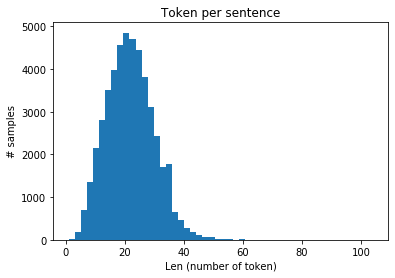

In [30]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

# Data Preprocessing
Before feeding the data into the model, we have to preprocess the text.
We will use the word2idx dictionary to convert each word to a corresponding integer ID and the tag2idx to do the same for the labels. Representing words as integers saves a lot of memory!
In order to feed the text into our Bi-LSTM-CRF, all texts should be the same length. We ensure this using the sequence.pad_sequences() method and MAX_LEN variable. All texts longer than MAX_LEN are truncated and shorter texts are padded to get them to the same length.
The Tokens per sentence plot (see above) is useful for setting the MAX_LEN training hyperparameter.

In [41]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 33351
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 10
Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [14737 15580 24597  9874  1980  2478 25286 14005 30521 12223  9905 33030
 23173 28481  9793 12223 16036 15580  5178 27545 21152 34455  6008 11465
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0

# Bidirectional LSTM-CRF Models for Sequence Tagging.
https://arxiv.org/pdf/1508.01991v1.pdf

In [42]:
#don't put mask_zero = True causes problems
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=len(words)+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=False)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 75)                0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 75, 50)            5050      
_________________________________________________________________
crf_16 (CRF)                 (None, 75, 18)            1278      
Total params: 738,328
Trainable params: 738,328
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=0.1, verbose=2)


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
 - 119s - loss: 0.1263 - crf_viterbi_accuracy: 0.9644 - val_loss: 0.0313 - val_crf_viterbi_accuracy: 0.9852
Epoch 2/5
 - 111s - loss: 0.0140 - crf_viterbi_accuracy: 0.9876 - val_loss: 7.3558e-04 - val_crf_viterbi_accuracy: 0.9888
Epoch 3/5
 - 103s - loss: -1.1778e-02 - crf_viterbi_accuracy: 0.9902 - val_loss: -1.9348e-02 - val_crf_viterbi_accuracy: 0.9898
Epoch 4/5
 - 103s - loss: -3.1495e-02 - crf_viterbi_accuracy: 0.9912 - val_loss: -3.6928e-02 - val_crf_viterbi_accuracy: 0.9901
Epoch 5/5
 - 103s - loss: -4.9408e-02 - crf_viterbi_accuracy: 0.9919 - val_loss: -5.3870e-02 - val_crf_viterbi_accuracy: 0.9903


In [44]:
# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [45]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

/Users/patsnap/anaconda2/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        29
       B-eve       0.67      0.22      0.33        45
       B-geo       0.85      0.89      0.87      3809
       B-gpe       0.97      0.92      0.94      1534
       B-nat       0.00      0.00      0.00        33
       B-org       0.76      0.70      0.73      2030
       B-per       0.84      0.80      0.82      1702
       B-tim       0.91      0.87      0.89      1951
       I-art       0.00      0.00      0.00        24
       I-eve       0.17      0.02      0.04        43
       I-geo       0.76      0.82      0.79       766
       I-gpe       1.00      0.44      0.62        18
       I-nat       0.00      0.00      0.00         9
       I-org       0.76      0.75      0.76      1673
       I-per       0.84      0.87      0.85      1702
       I-tim       0.80      0.73      0.76       618
           O       0.99      0.99      0.99     89350
         PAD       1.00    

#evaluate on some sample of test set

In [46]:
i = np.random.randint(0,X_te.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 1277 of 4796 (Test Set)
Word           ||True ||Pred
The            : O     O
pro-Western    : B-org O
Mr.            : B-per B-per
Tadic          : B-org I-per
was            : O     O
not            : O     O
hurt           : O     O
.              : O     O


In [47]:
from ipywidgets import interact_manual
from ipywidgets import widgets

import re
import string

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
    
def get_prediction(sentence):
    test_sentence = tokenize(sentence) # Tokenization
    # Preprocessing
    x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=word2idx["PAD"], maxlen=MAX_LEN)
    # Evaluation
    p = model.predict(np.array([x_test_sent[0]]))
    p = np.argmax(p, axis=-1)
    # Visualization
    print("{:15}||{}".format("Word", "Prediction"))
    print(30 * "=")
    for w, pred in zip(test_sentence, p[0]):
        print("{:15}: {:5}".format(w, idx2tag[pred]))

interact_manual(get_prediction, sentence=widgets.Textarea(placeholder='Type your sentence here'));

interactive(children=(Textarea(value='', description='sentence', placeholder='Type your sentence here'), Butto…

In [49]:
# import pickle

# # Saving Vocab
# with open('models/word_to_index.pickle', 'wb') as handle:
#     pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# # Saving Vocab
# with open('models/tag_to_index.pickle', 'wb') as handle:
#     pickle.dump(tag2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# # Saving Model Weight
# model.save_weights('models/lstm_crf_weights.h5')